<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Данные" data-toc-modified-id="Данные-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Данные</a></span></li><li><span><a href="#Выборки" data-toc-modified-id="Выборки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Выборки</a></span></li><li><span><a href="#Предобработка-текста" data-toc-modified-id="Предобработка-текста-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка текста</a></span><ul class="toc-item"><li><span><a href="#Символы" data-toc-modified-id="Символы-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Символы</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Частота-слов" data-toc-modified-id="Частота-слов-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Частота слов</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Результаты" data-toc-modified-id="Результаты-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Результаты</a></span></li></ul></li><li><span><a href="#Проверка-на-вменяемость" data-toc-modified-id="Проверка-на-вменяемость-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка на вменяемость</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Классификация комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Задача:  
Обучить модель классифицировать комментарии на позитивные и негативные

Для этого имеются данные с разметкой о токсичности правок.  
F1-метрика должна быть не меньше 0.75.

In [1]:
import re
import nltk
import scipy
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import lightgbm as lgb

from tqdm import notebook
from nltk import word_tokenize, pos_tag, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from scipy.sparse import vstack
from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.utils import shuffle
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

In [2]:
np.random.seed(57)

## Данные

In [3]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
data

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [5]:
data.drop(data.columns[0], axis=1, inplace=True)

In [6]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [7]:
data.duplicated().sum()

0

In [8]:
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


## Выборки

Я думаю, что 160 тысяч строк будут слишком долго обрабатываться, поэтому нужно взять выборку в 40000 строк.

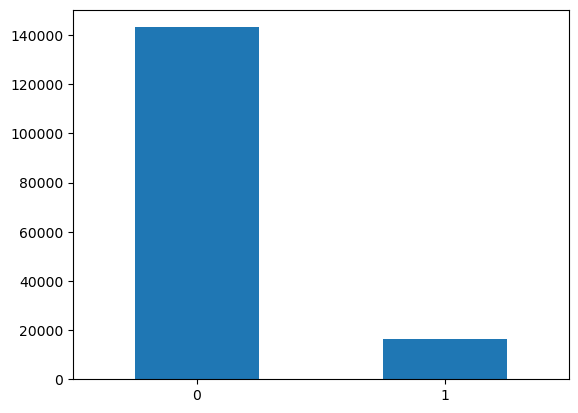

In [9]:
data['toxic'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

Налицо серьёзный дисбаланс классов.

Думаю, тестовую выборку нужно уже сейчас выделить, чтоы потом можно было экспериментировать с тренировочной.

In [10]:
data_test, data_valid, data_train = np.split(shuffle(data), [10000, 20000])
print(data_test.shape)
print(data_valid.shape)
print(data_train.shape)

(10000, 2)
(10000, 2)
(139292, 2)


Попробуем две тренировочные выборки: обычную и с учётом дисбаланса классов.

In [11]:
sample_train = data_train.sample(30000)
sample_train

,text,toxic
154933,"""\nYou're welcome. I do try my best. tlk. cntr...",0
5075,"""\nAt best, you could have deleted that portio...",0
82781,"""\n\nI agree that Raven has has a lot to do wi...",0
137923,Thank You\nKindly have a look here .,0
21756,"Will, whenever they 'saw him' and whenever th...",0
...,...,...
86866,"""\n\n Beware of the Leopard \n\nAfter reading ...",0
145377,"""\n Jezhotwells, you appear partisan in starti...",0
140664,Support . –For the numerous reasons already g...,0
64157,Band History\n\nShannon actually was in Mensre...,0


In [12]:
data_neg = data_train[data_train['toxic'] == 0]
data_pos = data_train[data_train['toxic'] == 1]

sample_train_balanced = pd.concat([data_neg.sample(20000), data_pos.sample(10000)])
sample_train_balanced = shuffle(sample_train_balanced)

sample_train_balanced

,text,toxic
133857,Oh I would like to ad that the reason for my b...,0
124188,Hear the voices in my head. I swear to God it ...,0
23378,you need to re-read the purpose of wikipedia,0
106745,Please refrain from adding nonsense to Wikiped...,0
64563,PICTURE YOUY MOTHER WITH HER WRINKLED UP ASS I...,1
...,...,...
35280,"You sir (or madam, or whatever the hell you ar...",1
46743,"Welcome!\n\nHello, Noplann, and welcome to Wik...",0
27072,Comment: These are not bad faith nomination. I...,0
47336,""", 15 August 2013 (UTC)\nHow can you write suc...",1


Тестовую выборку надо будет преобразовывать на основе тренировочной, поэтому сделаем копию.

In [13]:
samples = {}
samples['train'] = {'raw': sample_train, 'balanced': sample_train_balanced}
samples['valid'] = {'raw': data_valid, 'balanced': data_valid.copy()}
samples['test'] = {'raw': data_test, 'balanced': data_test.copy()}

Словарь для сокращения кода.

In [14]:
samples['train']['balanced']['toxic'].value_counts()

0    20000
1    10000
Name: toxic, dtype: int64

## Предобработка текста

In [15]:
samples['train']['raw']

,text,toxic
154933,"""\nYou're welcome. I do try my best. tlk. cntr...",0
5075,"""\nAt best, you could have deleted that portio...",0
82781,"""\n\nI agree that Raven has has a lot to do wi...",0
137923,Thank You\nKindly have a look here .,0
21756,"Will, whenever they 'saw him' and whenever th...",0
...,...,...
86866,"""\n\n Beware of the Leopard \n\nAfter reading ...",0
145377,"""\n Jezhotwells, you appear partisan in starti...",0
140664,Support . –For the numerous reasons already g...,0
64157,Band History\n\nShannon actually was in Mensre...,0


Нужно оставить только буквы и провести лемматизацию.

### Символы

In [16]:
samples['train']['raw']

,text,toxic
154933,"""\nYou're welcome. I do try my best. tlk. cntr...",0
5075,"""\nAt best, you could have deleted that portio...",0
82781,"""\n\nI agree that Raven has has a lot to do wi...",0
137923,Thank You\nKindly have a look here .,0
21756,"Will, whenever they 'saw him' and whenever th...",0
...,...,...
86866,"""\n\n Beware of the Leopard \n\nAfter reading ...",0
145377,"""\n Jezhotwells, you appear partisan in starti...",0
140664,Support . –For the numerous reasons already g...,0
64157,Band History\n\nShannon actually was in Mensre...,0


In [17]:
for dataframe in samples['train'].values():
    dataframe['clear'] = dataframe['text'].apply(
        lambda text: ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).split()))

for dataframe in samples['valid'].values():
    dataframe['clear'] = dataframe['text'].apply(
        lambda text: ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).split()))       
    
for dataframe in samples['test'].values():
    dataframe['clear'] = dataframe['text'].apply(
        lambda text: ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).split()))    

In [18]:
samples['train']['raw']

,text,toxic,clear
154933,"""\nYou're welcome. I do try my best. tlk. cntr...",0,You re welcome I do try my best tlk cntrb
5075,"""\nAt best, you could have deleted that portio...",0,At best you could have deleted that portion of...
82781,"""\n\nI agree that Raven has has a lot to do wi...",0,I agree that Raven has has a lot to do with th...
137923,Thank You\nKindly have a look here .,0,Thank You Kindly have a look here
21756,"Will, whenever they 'saw him' and whenever th...",0,Will whenever they saw him and whenever they w...
...,...,...,...
86866,"""\n\n Beware of the Leopard \n\nAfter reading ...",0,Beware of the Leopard After reading your comme...
145377,"""\n Jezhotwells, you appear partisan in starti...",0,Jezhotwells you appear partisan in starting an...
140664,Support . –For the numerous reasons already g...,0,Support For the numerous reasons already given...
64157,Band History\n\nShannon actually was in Mensre...,0,Band History Shannon actually was in Mensrea b...


От лишних символов избавились.

### Лемматизация

In [19]:
lemm = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/leonid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/leonid/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/leonid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/leonid/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [20]:
for dataframe in samples['train'].values():
    dataframe['lemm_text'] = dataframe['clear'].apply(
    lambda text: ' '.join([lemm.lemmatize(word, pos=pos[0].lower()) 
                           if pos[0].lower() in wordnet._pos_names.values() 
                           else lemm.lemmatize(word) 
                           for word, pos in pos_tag(word_tokenize(text.lower()))]))

for dataframe in samples['valid'].values():
    dataframe['lemm_text'] = dataframe['clear'].apply(
    lambda text: ' '.join([lemm.lemmatize(word, pos=pos[0].lower()) 
                           if pos[0].lower() in wordnet._pos_names.values() 
                           else lemm.lemmatize(word) 
                           for word, pos in pos_tag(word_tokenize(text.lower()))]))    
    
for dataframe in samples['test'].values():
    dataframe['lemm_text'] = dataframe['clear'].apply(
    lambda text: ' '.join([lemm.lemmatize(word, pos=pos[0].lower()) 
                           if pos[0].lower() in wordnet._pos_names.values() 
                           else lemm.lemmatize(word) 
                           for word, pos in pos_tag(word_tokenize(text.lower()))]))

In [21]:
samples['train']['raw']

,text,toxic,clear,lemm_text
154933,"""\nYou're welcome. I do try my best. tlk. cntr...",0,You re welcome I do try my best tlk cntrb,you re welcome i do try my best tlk cntrb
5075,"""\nAt best, you could have deleted that portio...",0,At best you could have deleted that portion of...,at best you could have delete that portion of ...
82781,"""\n\nI agree that Raven has has a lot to do wi...",0,I agree that Raven has has a lot to do with th...,i agree that raven have have a lot to do with ...
137923,Thank You\nKindly have a look here .,0,Thank You Kindly have a look here,thank you kindly have a look here
21756,"Will, whenever they 'saw him' and whenever th...",0,Will whenever they saw him and whenever they w...,will whenever they saw him and whenever they b...
...,...,...,...,...
86866,"""\n\n Beware of the Leopard \n\nAfter reading ...",0,Beware of the Leopard After reading your comme...,beware of the leopard after read your comment ...
145377,"""\n Jezhotwells, you appear partisan in starti...",0,Jezhotwells you appear partisan in starting an...,jezhotwells you appear partisan in start an ed...
140664,Support . –For the numerous reasons already g...,0,Support For the numerous reasons already given...,support for the numerous reason already give b...
64157,Band History\n\nShannon actually was in Mensre...,0,Band History Shannon actually was in Mensrea b...,band history shannon actually be in mensrea be...


In [22]:
corpus = {}
target = {}

corpus['raw'] = {'train': samples['train']['raw']['lemm_text'], 
                 'valid': samples['valid']['raw']['lemm_text'], 
                 'test': samples['test']['raw']['lemm_text']}
corpus['balanced'] = {'train': samples['train']['balanced']['lemm_text'], 
                      'valid': samples['valid']['balanced']['lemm_text'], 
                      'test': samples['test']['balanced']['lemm_text']}

target['raw'] = {'train': samples['train']['raw']['toxic'], 
                 'valid': samples['valid']['raw']['toxic'], 
                 'test': samples['test']['raw']['toxic']}
target['balanced'] = {'train': samples['train']['balanced']['toxic'], 
                      'valid': samples['valid']['balanced']['toxic'], 
                      'test': samples['test']['balanced']['toxic']}

In [23]:
corpus['balanced']['train']

133857    oh i would like to ad that the reason for my b...
124188    hear the voice in my head i swear to god it so...
23378          you need to re read the purpose of wikipedia
106745    please refrain from add nonsense to wikipedia ...
64563     picture youy mother with her wrinkle up as in ...
                                ...                        
35280     you sir or madam or whatever the hell you be b...
46743     welcome hello noplann and welcome to wikipedia...
27072     comment these be not bad faith nomination i tr...
47336     august utc how can you write such putrid filth...
71037                     i m sorry i actually know the law
Name: lemm_text, Length: 30000, dtype: object

In [24]:
target['raw']['valid']

80902     0
76700     1
133696    0
84672     0
1064      0
         ..
49644     0
135981    0
133461    0
115907    0
97731     0
Name: toxic, Length: 10000, dtype: int64

### Частота слов

Уберём частые неинформативные слова.

In [25]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/leonid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
tf_idf = {}

for approach in 'raw', 'balanced':
    count_tf_idf = TfidfVectorizer(stop_words=stop_words) 
    count_tf_idf.fit(pd.concat([corpus[approach]['train'], corpus[approach]['valid']]))
    
    tf_idf[approach] = {'train': count_tf_idf.transform(corpus[approach]['train']), 
                        'valid': count_tf_idf.transform(corpus[approach]['valid']), 
                        'test': count_tf_idf.transform(corpus[approach]['test'])}

In [27]:
print(tf_idf['raw']['train'].shape)
print(tf_idf['raw']['valid'].shape)
print(tf_idf['raw']['test'].shape)
print()
print(tf_idf['balanced']['train'].shape)
print(tf_idf['balanced']['valid'].shape)
print(tf_idf['balanced']['test'].shape)

(30000, 67135)
(10000, 67135)
(10000, 67135)

(30000, 65603)
(10000, 65603)
(10000, 65603)


## Обучение

Рассмотрим логистическую регрессию, решающее дерево, случайный лес и LightGBM.

### Логистическая регрессия

In [28]:
%%time
params_grid = {'l1_ratio': [0, 0.3, 0.7, 1], 
               'class_weight': [None, 'balanced']}

model = GridSearchCV(estimator=LogisticRegression(solver='saga', 
                                                  penalty='elasticnet', 
                                                  max_iter=1000), 
                     param_grid=params_grid, 
                     scoring='f1')

model.fit(vstack((tf_idf['raw']['train'], tf_idf['raw']['valid'])), 
          pd.concat([target['raw']['train'], target['raw']['valid']]))
print(model.best_params_)
print(model.best_score_)

/home/leonid/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/leonid/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/leonid/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/leonid/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/leonid/anaconda3/envs/practicum/li

{'class_weight': 'balanced', 'l1_ratio': 0.7}
0.7201254626986577
CPU times: user 1h 35min 50s, sys: 675 ms, total: 1h 35min 51s
Wall time: 1h 36min


/home/leonid/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


{'class_weight': 'balanced', 'l1_ratio': 0.7}  
0.7201254626986577  
CPU times: user 1h 35min 50s, sys: 675 ms, total: 1h 35min 51s  
Wall time: 1h 36min

In [29]:
%%time
best_f1 = 0
best_model = None
for l1_ratio in [0, 0.3, 0.7, 1]:
    for class_weight in [None, 'balanced']:
        model = LogisticRegression(solver='saga', 
                                   l1_ratio=l1_ratio, 
                                   class_weight=class_weight, 
                                   penalty='elasticnet', 
                                   max_iter=1000)
        model.fit(tf_idf['balanced']['train'], target['balanced']['train'])
        predictions_valid = model.predict(tf_idf['balanced']['valid'])
        current_f1 = f1_score(target['balanced']['valid'], predictions_valid)
        if current_f1 > best_f1:
            best_model = model
            best_f1 = current_f1
print(model.get_params())
print('F1-score:', best_f1)

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 1, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
F1-score: 0.7534246575342466
CPU times: user 43.5 s, sys: 16 ms, total: 43.5 s
Wall time: 43.6 s


{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True,  'intercept_scaling': 1, 'l1_ratio': 1, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs':  None, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001,  'verbose': 0, 'warm_start': False}  
F1-score: 0.7534246575342466  
CPU times: user 43.5 s, sys: 16 ms, total: 43.5 s  
Wall time: 43.6 s

### Решающее дерево

In [30]:
%%time
params_grid = {'max_depth': range(1, 50, 7), 
               'class_weight': [None, 'balanced']}

model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=57), 
                     param_grid=params_grid, 
                     scoring='f1')

model.fit(vstack((tf_idf['raw']['train'], tf_idf['raw']['valid'])), 
          pd.concat([target['raw']['train'], target['raw']['valid']]))
print(model.best_params_)
print(model.best_score_)

{'class_weight': None, 'max_depth': 43}
0.6860495486690436
CPU times: user 5min 8s, sys: 795 ms, total: 5min 9s
Wall time: 5min 9s


{'class_weight': None, 'max_depth': 43}  
0.6860495486690436  
CPU times: user 5min 8s, sys: 795 ms, total: 5min 9s  
Wall time: 5min 9s

In [31]:
%%time
best_f1 = 0
best_model = None
for max_depth in range(1, 50, 7):
    for class_weight in [None, 'balanced']:
        model = DecisionTreeClassifier(max_depth=max_depth, 
                                       class_weight=class_weight, 
                                       random_state=57)
        model.fit(tf_idf['balanced']['train'], target['balanced']['train'])
        predictions_valid = model.predict(tf_idf['balanced']['valid'])
        current_f1 = f1_score(target['balanced']['valid'], predictions_valid)
        if current_f1 > best_f1:
            best_model = model
            best_f1 = current_f1
print(model.get_params())
print('F1-score:', best_f1)

{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 43, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 57, 'splitter': 'best'}
F1-score: 0.6796326310102648
CPU times: user 55.8 s, sys: 3.99 ms, total: 55.8 s
Wall time: 55.9 s


{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 43,  'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,  'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2,  'min_weight_fraction_leaf': 0.0, 'random_state': 57, 'splitter': 'best'}  
F1-score: 0.6796326310102648  
CPU times: user 55.8 s, sys: 3.99 ms, total: 55.8 s  
Wall time: 55.9 s

### Случайный лес

In [32]:
%%time
params_grid = {'max_depth': range(1, 22, 5), 
               'n_estimators': range(1, 302, 100)}

model = GridSearchCV(estimator=RandomForestClassifier(random_state=57), 
                     param_grid=params_grid, 
                     scoring='f1')

model.fit(vstack((tf_idf['raw']['train'], tf_idf['raw']['valid'])), 
          pd.concat([target['raw']['train'], target['raw']['valid']]))
print(model.best_params_)
print(model.best_score_)

{'max_depth': 21, 'n_estimators': 1}
0.16948032682016934
CPU times: user 15min 25s, sys: 963 ms, total: 15min 26s
Wall time: 15min 28s


{'max_depth': 21, 'n_estimators': 1}  
0.16948032682016934  
CPU times: user 15min 25s, sys: 963 ms, total: 15min 26s  
Wall time: 15min 28s

In [33]:
%%time
best_f1 = 0
best_model = None
for max_depth in range(1, 22, 5):
    for n_estimators in range(1, 302, 100):
        model = RandomForestClassifier(max_depth=max_depth, 
                                       n_estimators=n_estimators, 
                                       random_state=57)
        model.fit(tf_idf['balanced']['train'], target['balanced']['train'])
        predictions_valid = model.predict(tf_idf['balanced']['valid'])
        current_f1 = f1_score(target['balanced']['valid'], predictions_valid)
        if current_f1 > best_f1:
            best_model = model
            best_f1 = current_f1
print(model.get_params())
print('F1-score:', best_f1)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 21, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 301, 'n_jobs': None, 'oob_score': False, 'random_state': 57, 'verbose': 0, 'warm_start': False}
F1-score: 0.16498054474708168
CPU times: user 2min 30s, sys: 108 ms, total: 2min 30s
Wall time: 2min 30s


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini',  'max_depth': 21, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None,  'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1,  'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 301, 'n_jobs':  None, 'oob_score': False, 'random_state': 57, 'verbose': 0, 'warm_start': False}  
F1-score: 0.16498054474708168  
CPU times: user 2min 30s, sys: 108 ms, total: 2min 30s  
Wall time: 2min 30s

Не очень понятно, почему хуже решающего дерева. Глубина достаточная.

### LightGBM

In [34]:
%%time
params_grid = {'learning_rate': [0.05, 0.1, 0.2], 
               'n_estimators': [50, 100, 150, 200], 
               'colsample_bytree': [0.5, 0.7, 1.0]}

model = GridSearchCV(estimator=lgb.LGBMClassifier(objective='binary', 
                                                  random_state=57), 
                     param_grid=params_grid, 
                     scoring='f1')

model.fit(vstack((tf_idf['raw']['train'], tf_idf['raw']['valid'])), 
          pd.concat([target['raw']['train'], target['raw']['valid']]))
print(model.best_params_)
print(model.best_score_)

{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'n_estimators': 150}
0.7332954922894052
CPU times: user 4h 23min 19s, sys: 4min 48s, total: 4h 28min 7s
Wall time: 34min 12s


{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'n_estimators': 150}  
0.7332954922894052  
CPU times: user 4h 23min 19s, sys: 4min 48s, total: 4h 28min 7s  
Wall time: 34min 12s

In [35]:
%%time
best_f1 = 0
best_model = None
for learning_rate in [0.05, 0.1, 0.2]:
    for n_estimators in [50, 100, 150, 200]:
        for colsample_bytree in [0.5, 0.7, 1.0]:
            model = lgb.LGBMClassifier(objective='binary', 
                                       learning_rate=learning_rate, 
                                       n_estimators=n_estimators, 
                                       colsample_bytree=colsample_bytree, 
                                       random_state=57)
            model.fit(tf_idf['balanced']['train'], target['balanced']['train'])
            predictions_valid = model.predict(tf_idf['balanced']['valid'])
            current_f1 = f1_score(target['balanced']['valid'], predictions_valid)
            if current_f1 > best_f1:
                best_model = model
                best_f1 = current_f1
print(model.get_params())
print('F1-score:', best_f1)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.2, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'binary', 'random_state': 57, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
F1-score: 0.7537840565085772
CPU times: user 47min 43s, sys: 51 s, total: 48min 34s
Wall time: 6min 9s


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type':  'split', 'learning_rate': 0.2, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight':  0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 31,  'objective': 'binary', 'random_state': 57, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent':  'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}  
F1-score: 0.7537840565085772  
CPU times: user 47min 43s, sys: 51 s, total: 48min 34s   
Wall time: 6min 9s

### Результаты

||Исходная выборка|Сбалансированная выборка|
|-|-|-|
|Логистическая регрессия|0.720|0.753|
|Решающее дерево|0.686|0.680|
|Случайный лес|0.170|0.365|
|LightGBM|0.733|**0.754**|

Таким образом, тестируем LightGBM.

## Проверка на вменяемость

In [37]:
cross_val_score(DummyClassifier(strategy='stratified'), 
                tf_idf['balanced']['train'], 
                target['balanced']['train'], scoring='f1').mean()

0.32716951865226346

С другой стороны, если он только в нули попадает, а логистическая регрессия – нет, то в ней может быть смысл.

In [38]:
def plot_confusion_matrix(model, features_valid, target_valid):
    predicted_valid = model.predict(features_valid)

    print('Confusion matrix:')
    print(confusion_matrix(target_valid, predicted_valid))
    
    fig, ax = plt.subplots()
    fig = sb.heatmap(confusion_matrix(target_valid, predicted_valid, normalize='true'), 
                     annot=True)
    plt.yticks(rotation=0)
    ax.set_ylabel('Answers', rotation=0);
    ax.set_xlabel('Predictions');
    ax.yaxis.labelpad = 20
    plt.show()

In [39]:
feautres_train, features_valid, target_train, target_valid = train_test_split(
    tf_idf['raw']['train'], target['raw']['train'])

Confusion matrix:
[[6042  704]
 [ 671   83]]


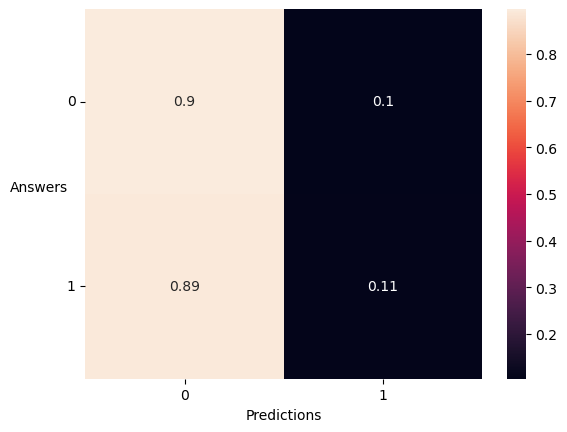

In [40]:
model = DummyClassifier(strategy='stratified')
model.fit(features_valid, target_valid)
plot_confusion_matrix(model, features_valid, target_valid)

Буду сравнивать с этим.

## Тестирование

0.782033096926714
Confusion matrix:
[[8712  263]
 [ 198  827]]


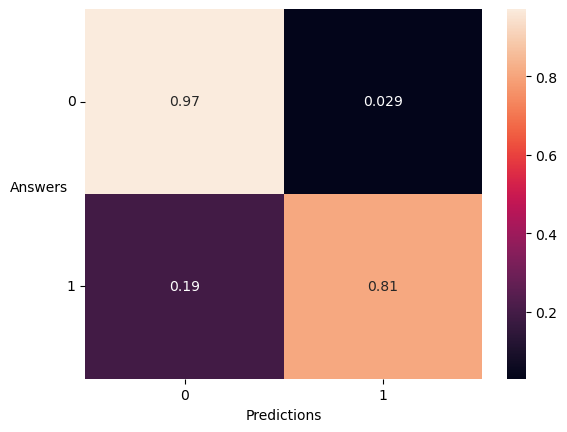

In [42]:
model = lgb.LGBMClassifier(objective='binary', 
                           learning_rate=0.2, 
                           n_estimators=200, 
                           colsample_bytree=1.0, 
                           random_state=57)

model.fit(vstack((tf_idf['balanced']['train'], tf_idf['balanced']['valid'])), 
          pd.concat([target['balanced']['train'], target['balanced']['valid']]))

predictions = model.predict(tf_idf['balanced']['test'])
print(f1_score(target['balanced']['test'], predictions))
plot_confusion_matrix(model, tf_idf['balanced']['test'], target['balanced']['test'])

Ради интереса попробуем также регрессию.

0.7357640311347808
Confusion matrix:
[[8457  518]
 [ 127  898]]


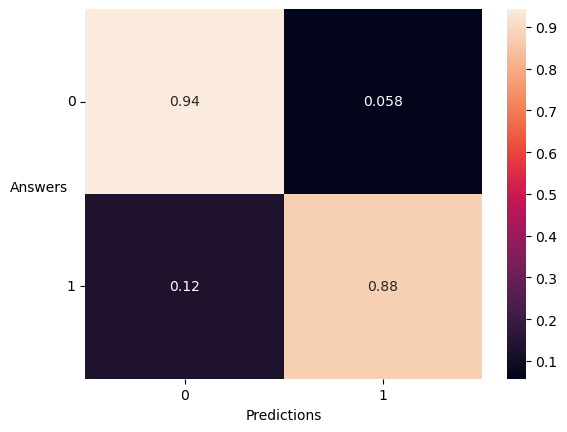

In [43]:
model = LogisticRegression(solver='saga', 
                           l1_ratio=1.0, 
                           class_weight='balanced', 
                           penalty='elasticnet', 
                           max_iter=1000)

model.fit(vstack((tf_idf['balanced']['train'], tf_idf['balanced']['valid'])), 
          pd.concat([target['balanced']['train'], target['balanced']['valid']]))

predictions = model.predict(tf_idf['balanced']['test'])
print(f1_score(target['balanced']['test'], predictions))
plot_confusion_matrix(model, tf_idf['balanced']['test'], target['balanced']['test'])

F1-мера хуже, хотя полнота выше, чем в случае с бустингом.

## Выводы

1. Данные представляют собой 160 тысяч англоязычных комментариев. 
2. В данных наблюдается дисбаланс классов (10% обозначены как токсичные).
3. Для обучения и тестирования была взята выбока в 50000 комментариев.
4. Перед обучением была проведена лемматизация функцией WordNetLemmatizer()
5. Для обучения были опробованы логистическая регрессия, решающее дерево, случайный лес и LightGBM.
6. Наилучшую f1-меру показала модель LightGBM, обученная на выборке с апсэмплингом.
7. При тестировании эта модель показала f1-меру, равную 0.782.